In [1]:
import pandas as pd
import numpy as np
import collections
import theano
import torch

from acgan import torch_gan

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/morgan/venv/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7500 on context None
Mapped name None to device cuda: GeForce GTX 1070 (0000:01:00.0)
/home/morgan/venv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using Theano backend.


In [2]:
gen = torch_gan.make_model_from_block(torch_gan.CNNTransposeBlock, 
                                       z_dim=100, 
                                       n_channels=[512, 256, 128, 64],
                                       kernel_sizes=[4, 4, 4, 4],
                                       strides=[1, 2, 2, 2],
                                       paddings=[0, 1, 1, 1])

gen.add_module(name='output_conv', module=torch.nn.ConvTranspose2d(64, 3, 4, 2, 1))
gen.add_module(name='output_activ', module=torch.nn.Tanh())

In [3]:
disc = torch_gan.make_model_from_block(torch_gan.CNNBlock,
                                       z_dim=3,
                                       n_channels=[64, 128, 256, 512],
                                       kernel_sizes=[4, 4, 4, 4],
                                       strides=[2, 2, 2, 2],
                                       paddings=[1, 1, 1, 1]
                                      )
disc.add_module(name='output_conv', module=torch.nn.Conv2d(512, 1, 4, stride=1))
disc.add_module(name='output_activ', module=torch.nn.Sigmoid())

***

In [4]:
import torch.utils.data
import torchvision.datasets as dset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt

In [5]:
# Root directory for dataset
dataroot = "/export/datasets/celeba"

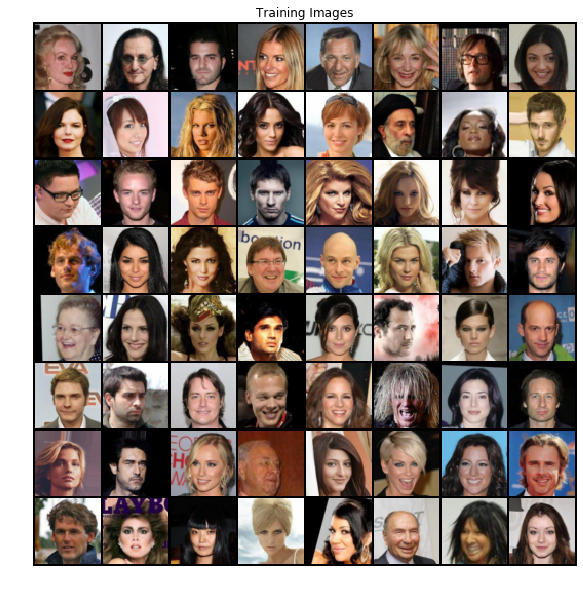

In [6]:
image_size = 64
batch_size = 64
workers = 4

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Random Sampling dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=2000*batch_size),
                                         shuffle=False,
                                         num_workers=workers)
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
                        (1,2,0)))

In [7]:
gen.to(device);
disc.to(device);

In [8]:
trainer = torch_gan.GANTrainer(gen, disc, dataloader,
                               n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size)))

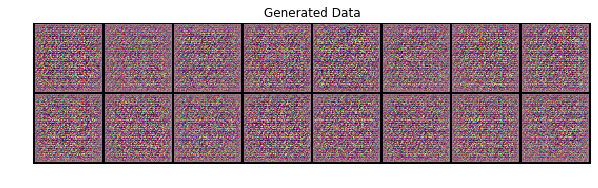

In [9]:
trainer.display_batch();

In [10]:
from IPython.display import display
import torch
fixed_outputs = list()
output_every = 7
fixed_noise = torch.randn(4, 100, 1, 1, device=trainer.device)

batch_f = lambda _tr, _epoch: fixed_outputs.append(_tr.gen_model(fixed_noise).cpu().detach().numpy())

res = trainer.train(3, batch_cb_delta=output_every,
                    batch_callbacks=dict(batch_fixed_gen=batch_f),
                    #epoch_callbacks=dict(plot_sample=lambda _tr, _epoch: display(_tr.display_batch(4, 
                    #                                                         title='Epoch %d' % _tr.epochs_trained)))
                   
                   )

In [13]:
import ipywidgets

_ifunc = lambda i=0: trainer.display_batch(batch_data=torch.tensor(fixed_outputs[i]), figsize=(12, 12))

ipywidgets.interact(_ifunc, i=ipywidgets.IntSlider(value=0, min=0, max=len(fixed_outputs)))

interactive(children=(IntSlider(value=0, description='i', max=859), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i=0)>

***

In [18]:
loss_df = pd.concat(pd.DataFrame(dict(epoch=ei, **e)).reset_index().rename(columns=dict(index='batch_num'))
                    for ei, e in enumerate(trainer.epoch_losses))

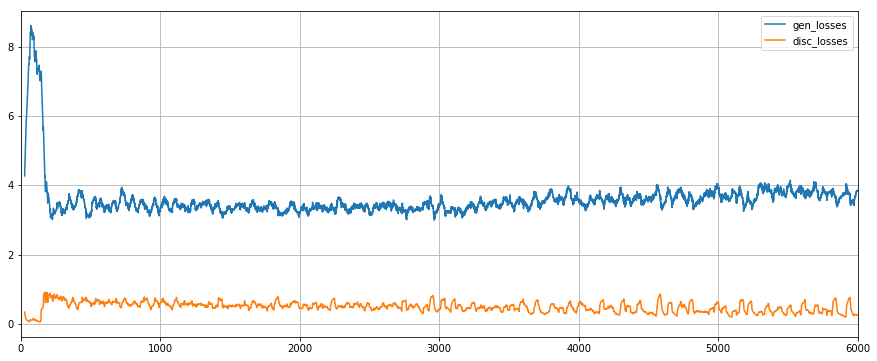

In [40]:
(loss_df
 .sort_values(['epoch', 'batch_num'])
 .reset_index(drop=True)
 .rolling(30).mean()
 .plot(y=['gen_losses', 'disc_losses'], figsize=(15, 6), grid=True))